In [5]:
import numpy as np
import gymnasium as gym
from tiles3 import tiles, IHT 
import matplotlib.pyplot as plt

In [31]:
# タイルコーディングの初期化
def initialize_tile_coding(num_tilings, tile_width, state_bounds, action_size):
    """ タイルコーディングの初期化 
    Args:
        num_tilings: タイルの重ね合わせ数
        tile_width: タイルの幅
        state_bounds: 状態の最小値と最大値
        action_size: 行動の数
    Returns:
        iht: IHTオブジェクト
        tile_widths: 各次元のタイル幅
        num_tilings: タイルの重ね合わせ数
    """
    iht_size = 4096  # タイルの総数（メモリサイズ）
    iht = IHT(iht_size)
    tile_widths = [tile_width for _ in state_bounds]  # 各次元のタイル幅
    return iht, tile_widths, num_tilings

# 特徴ベクトルの生成
def get_features(state, action, iht, tile_widths, num_tilings):
    """ 特徴ベクトルの生成
    Args:
        state: 状態
        action: 行動
        iht: IHTオブジェクト
        tile_widths: 各次元のタイル幅
        num_tilings: タイルの重ね合わせ数  
    Returns:
        features: 特徴ベクトル
    """
        # state が辞書型の場合、適切なキーを使用して値を取得
    if isinstance(state, dict):
        state = state['observation']  # 必要に応じて適切なキーを指定してください
    scaled_state = [state[i] / tile_widths[i] for i in range(len(state))]
    return tiles(iht, num_tilings, scaled_state + [action])

# アクションを選択（ε-greedy）
def epsilon_greedy(state, weights, epsilon, iht, tile_widths, num_tilings, action_size):
    if np.random.rand() < epsilon:  # 確率εでランダム選択
        return np.random.choice(action_size)
    else:  # 確率1-εで貪欲選択
        q_values = np.array([np.sum(weights[get_features(state, a, iht, tile_widths, num_tilings)]) for a in range(action_size)])
        return np.argmax(q_values)

# Sarsaによるエージェントの学習
def semi_gradient_sarsa_with_logging(env, num_episodes, alpha, gamma, epsilon, num_tilings, tile_width):
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    action_size = env.action_space.n
    iht, tile_widths, num_tilings = initialize_tile_coding(num_tilings, tile_width, state_bounds, action_size)
    weights = np.zeros(4096)  # タイルの数と一致
    episode_steps = []  # 各エピソードのステップ数を記録

    for episode in range(num_episodes):
        state,_ = env.reset()
        action = epsilon_greedy(state, weights, epsilon, iht, tile_widths, num_tilings, action_size)
        step_count = 0  # ステップ数のカウント

        while True:
            next_state, reward, done, truncated, _ = env.step(action)
            next_action = epsilon_greedy(next_state, weights, epsilon, iht, tile_widths, num_tilings, action_size)

            features = get_features(state, action, iht, tile_widths, num_tilings)
            next_features = get_features(next_state, next_action, iht, tile_widths, num_tilings) if not done else []

            # TDエラー計算
            q_hat = np.sum(weights[features])
            q_next = np.sum(weights[next_features]) if not done else 0
            td_error = reward + gamma * q_next - q_hat

            # 重み更新
            for feature in features:
                weights[feature] += alpha * td_error

            step_count += 1  # ステップ数を更新
            if done  or truncated:  # エピソード終了
                episode_steps.append(step_count)
                break

            state, action = next_state, next_action

        # エピソードごとの進捗を表示
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1} completed, Steps: {step_count}")

    return weights, episode_steps, iht, tile_widths, num_tilings



In [32]:
# エピソードごとのステップ数をプロット
def plot_episode_steps(episode_steps):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_steps, label="Steps per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Number of Steps")
    plt.title("Episode Steps Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# 学習されたコスト関数（価値関数の負値）をヒートマップで表示
def plot_cost_to_go(weights, iht, tile_widths, num_tilings):
    x = np.linspace(-1.2, 0.5, 50)  # 位置の範囲
    x_dot = np.linspace(-0.07, 0.07, 50)  # 速度の範囲
    X, Y = np.meshgrid(x, x_dot)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = [X[i, j], Y[i, j]]
            q_values = [np.sum(weights[get_features(state, a, iht, tile_widths, num_tilings)]) for a in range(3)]
            Z[i, j] = -np.max(q_values)  # コスト関数（価値の負値）

    plt.figure(figsize=(10, 7))
    plt.contourf(X, Y, Z, levels=20, cmap="viridis")
    plt.colorbar(label="Cost-to-Go (Negative Value Function)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Learned Cost-to-Go Function")
    plt.show()


Episode 10 completed, Steps: 200
Episode 20 completed, Steps: 200
Episode 30 completed, Steps: 200
Episode 40 completed, Steps: 200
Episode 50 completed, Steps: 200
Episode 60 completed, Steps: 178
Episode 70 completed, Steps: 173
Episode 80 completed, Steps: 200
Episode 90 completed, Steps: 200
Episode 100 completed, Steps: 182
Episode 110 completed, Steps: 200
Episode 120 completed, Steps: 200
Episode 130 completed, Steps: 187
Episode 140 completed, Steps: 161
Episode 150 completed, Steps: 200
Episode 160 completed, Steps: 200
Episode 170 completed, Steps: 158
Episode 180 completed, Steps: 200
Episode 190 completed, Steps: 157
Episode 200 completed, Steps: 173
Episode 210 completed, Steps: 200
Episode 220 completed, Steps: 163
Episode 230 completed, Steps: 200
Episode 240 completed, Steps: 171
Episode 250 completed, Steps: 200
Episode 260 completed, Steps: 190
Episode 270 completed, Steps: 170
Episode 280 completed, Steps: 191
Episode 290 completed, Steps: 156
Episode 300 completed, 

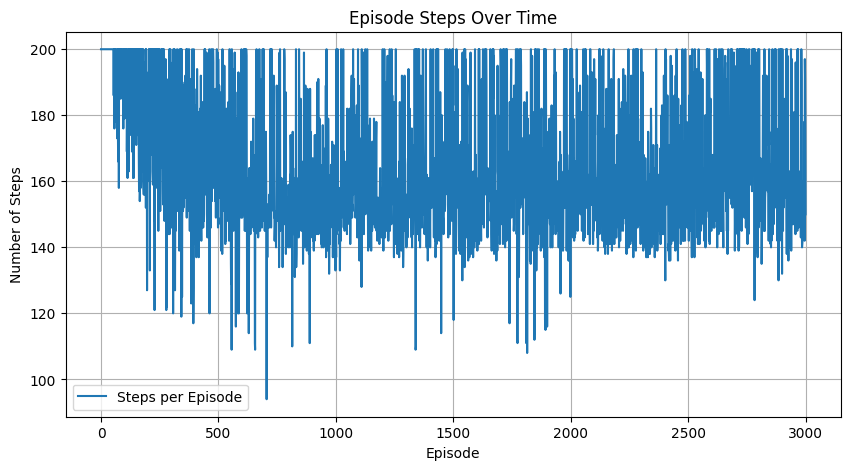

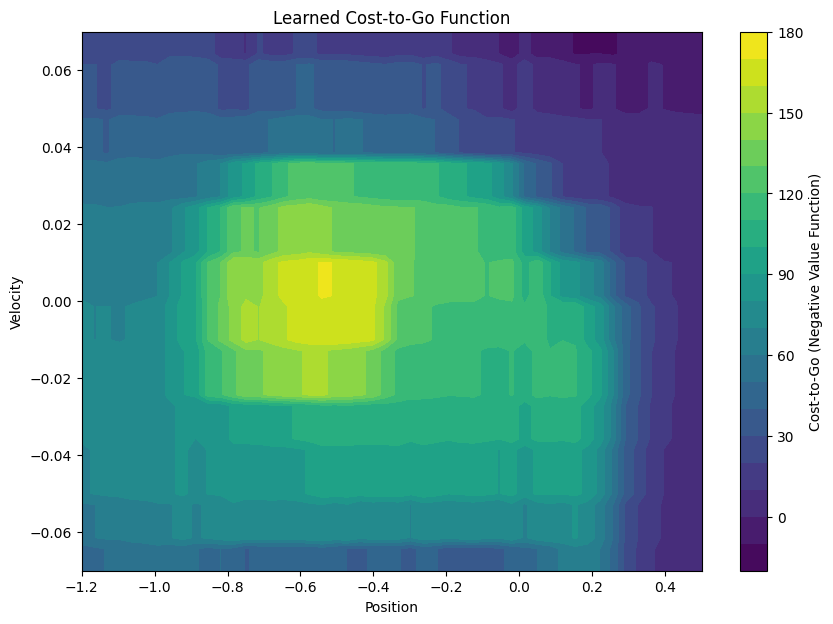

In [33]:
if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    num_episodes = 3000
    alpha = 0.1 / 8
    gamma = 1.0
    epsilon = 0.1
    num_tilings = 8
    tile_width = 0.1

    # セミグラデントSarsaで学習し、結果を記録
    weights, episode_steps, iht, tile_widths, num_tilings = semi_gradient_sarsa_with_logging(
        env, num_episodes, alpha, gamma, epsilon, num_tilings, tile_width
    )

    # エピソードごとのステップ数をプロット
    plot_episode_steps(episode_steps)

    # 学習されたコスト関数をヒートマップでプロット
    plot_cost_to_go(weights, iht, tile_widths, num_tilings)


epsilonの減衰

In [34]:
def get_epsilon(initial_epsilon, min_epsilon, decay_rate, episode):
    """
    探索率をエピソード数に応じて減少させる
    """
    return max(min_epsilon, initial_epsilon * (1 - decay_rate * episode))

In [37]:
def semi_gradient_sarsa_with_decay(env, num_episodes, alpha, gamma, initial_epsilon, min_epsilon, num_tilings, tile_width):
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    action_size = env.action_space.n
    iht, tile_widths, num_tilings = initialize_tile_coding(num_tilings, tile_width, state_bounds, action_size)
    weights = np.zeros(4096)  # タイルの数と一致
    episode_steps = []  # 各エピソードのステップ数を記録
    decay_rate = 1 / num_episodes  # 探索率の減少速度

    for episode in range(num_episodes):
        # エピソードごとに探索率を更新
        epsilon = get_epsilon(initial_epsilon, min_epsilon, decay_rate, episode)
        
        state,_ = env.reset()

        action = epsilon_greedy(state, weights, epsilon, iht, tile_widths, num_tilings, action_size)
        step_count = 0  # ステップ数のカウント

        while True:
            next_state, reward, done, truncated, _ = env.step(action)
            next_action = epsilon_greedy(next_state, weights, epsilon, iht, tile_widths, num_tilings, action_size)

            features = get_features(state, action, iht, tile_widths, num_tilings)
            next_features = get_features(next_state, next_action, iht, tile_widths, num_tilings) if not done else []

            # TDエラー計算
            q_hat = np.sum(weights[features])
            q_next = np.sum(weights[next_features]) if not done else 0
            td_error = reward + gamma * q_next - q_hat

            # 重み更新
            for feature in features:
                weights[feature] += alpha * td_error

            step_count += 1  # ステップ数を更新
            if done or truncated:
                episode_steps.append(step_count)
                break

            state, action = next_state, next_action

        # エピソードごとの進捗を表示
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1} completed, Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return weights, episode_steps, iht, tile_widths, num_tilings


Episode 10 completed, Steps: 200, Epsilon: 0.0997
Episode 20 completed, Steps: 200, Epsilon: 0.0994
Episode 30 completed, Steps: 200, Epsilon: 0.0990
Episode 40 completed, Steps: 200, Epsilon: 0.0987
Episode 50 completed, Steps: 200, Epsilon: 0.0984
Episode 60 completed, Steps: 200, Epsilon: 0.0980
Episode 70 completed, Steps: 163, Epsilon: 0.0977
Episode 80 completed, Steps: 200, Epsilon: 0.0974
Episode 90 completed, Steps: 179, Epsilon: 0.0970
Episode 100 completed, Steps: 166, Epsilon: 0.0967
Episode 110 completed, Steps: 200, Epsilon: 0.0964
Episode 120 completed, Steps: 200, Epsilon: 0.0960
Episode 130 completed, Steps: 162, Epsilon: 0.0957
Episode 140 completed, Steps: 200, Epsilon: 0.0954
Episode 150 completed, Steps: 200, Epsilon: 0.0950
Episode 160 completed, Steps: 200, Epsilon: 0.0947
Episode 170 completed, Steps: 200, Epsilon: 0.0944
Episode 180 completed, Steps: 177, Epsilon: 0.0940
Episode 190 completed, Steps: 159, Epsilon: 0.0937
Episode 200 completed, Steps: 199, Epsil

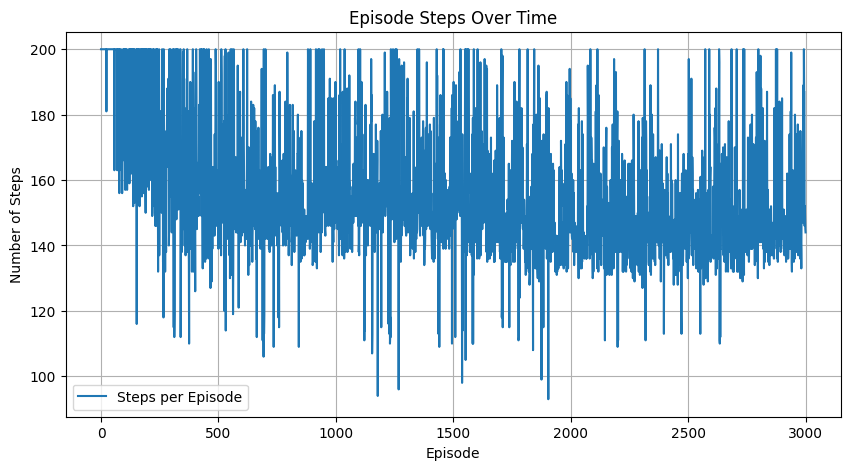

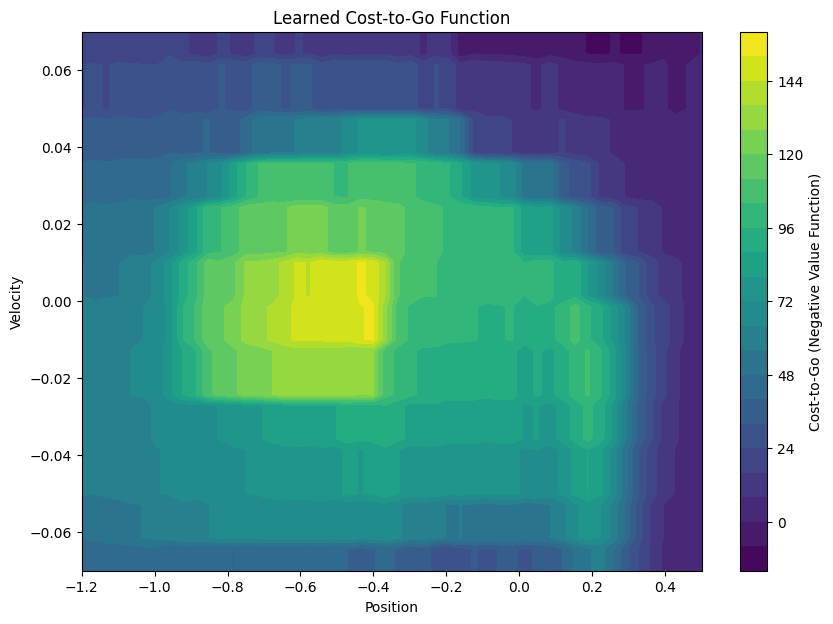

In [38]:
if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    num_episodes = 3000
    alpha = 0.1 / 8  # 学習率をタイル数で正規化
    gamma = 1.0
    initial_epsilon = 0.1  # 初期探索率
    min_epsilon = 0.01  # 最小探索率
    num_tilings = 8  # タイルの重ね合わせ数
    tile_width = 0.1  # タイルの幅

    # セミグラデントSarsaで学習し、探索率を減少させる
    weights, episode_steps, iht, tile_widths, num_tilings = semi_gradient_sarsa_with_decay(
        env, num_episodes, alpha, gamma, initial_epsilon, min_epsilon, num_tilings, tile_width
    )

    # エピソードごとのステップ数をプロット
    plot_episode_steps(episode_steps)

    # 学習されたコスト関数をヒートマップでプロット
    plot_cost_to_go(weights, iht, tile_widths, num_tilings)
